# <font color='red'> Cycle 01 - Clusters validation metrics </font>

1. Feature Engineering (FRM)
- Recency
- Frequency
 - Monetary
2. Cluster validation metrics
- WSS (Within-Cluster Sum of Square)
- SS (Silhouette Score)
3. Cluster Analysis
- Plot 3D
- Cluster Profile

# <font color='red'> Cycle 02 - Silhouette Analysis </font>

1. Feature Engineering (FRM)
- Avg ticket
2. Silhouette Analysis
3. Cluster Visualization
- UMAP
4. Cluster profile analysis
- Description of cluster centroids

# <font color='red'> Cycle 03 - Descriptive Statistical </font>

1. Descriptive Analysis
- Numerical attributes
- Categorical attributes
2. Feature Engineering
- Average recency
- Number of returns
3. Data Preparation
- Standard Scaler

# <font color='red'> Cycle 04 - Feature Engineering </font>

1. Variables Filtering
2. Feature Engineering
- Quantity of Purchases
- Quantity of Products Purchased
- Average Ticket Value
- Frequency
- Returns
- Basket Size
- Unique Basket Size
3. Data Preparation
- Standard Scaler

# <font color='red'> Cycle 05 - Embedding Study </font>

1. Univariate Analysis
- Remove outliers
- Statistic Framework for EDA
2. Bivariate Analaysis
- Pairplot
3. Embedding
- PCA
- UMAP
- TSNE
- Tree-Based

# 0.0 SOLUTION PLANNING (IOT)

**Input**
1. Business Problem
    - Select the most valuable customers to join a loyalty program (Insiders program).
#
2. Data
    - E-commerce sales over 1 year period.

**Output**

1. The indication of people who will be part of the Insiders program
    - List:          client_id | is_insider |
#
2. Report containing the solutions for the business questions

- Who are eligible to participate the Insiders program?

- How many customers will be part of the group?

- What are the mainly characteristics of there customers?

- What is the % of revenue coming of these customers?

- What's the revenue expectation for this group next month?

- What are the conditions for someone to be eligible for insiders?

- What are the conditions for someone to be removed from insiders?

- What is the guarantee that the Insiders program is best than the remaining base?

- What actions the marketing team can do for increasing the revenue?


#### Tasks

1. **Report with answers**:

- 1. Who are eligible to participate the Insiders program?
    - What is being eligible? What are the most valuable customers?
        - Shopping experience
        - Basket size
        - Higher LTV
        - Higher average ticket
        - Low probability of Churn 
        - Higher shopping probability
        - Low devolution rate
        - Positive reviews        
#
- 2. How many customers will be part of the group?
    - Quantity of customers
    - % of Insiders group

#
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    #
    - Write shopping characteristics:
        - Clustering features
#
- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
#
- 5. What's the revenue expectation for this group next month?
    - Insiders group LTV
    - Cohort analysis
#
- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity
    - The customer needs to be similar to someone that is present in the group
#
- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity
    - The customer needs to be non imilar to someone that is present in the group
#
- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B Test
    - Baysean A/B Test
    - Hypothesis test
#
- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New employees
    - New products


## 0.1 Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import re

from matplotlib import pyplot as plt
from IPython.display import HTML
from matplotlib import cm

from pandas_profiling import ProfileReport

from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc
from sklearn import ensemble as en

from plotly import express as px

## 0.2 Helper functions

## 0.3 Load dataset

In [6]:
# load data
df_raw = pd.read_csv(r"C:\Users\diego\OneDrive\Área de Trabalho\projects\insiders_clustering\data\Ecommerce.csv", encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)



In [7]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [13]:
# spliting NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [14]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [15]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [16]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive statistics

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [18]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
quantity,9.552250,3.00,218.081158,-80995.00,80995.0,-0.264076,119769.160031
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,186.506972,59005.719097
customer_id,16688.840453,16249.00,2911.411352,12346.00,22709.0,0.487449,-0.804287


<font color='red'>**Some points:**</font>
- The minimum of 'quantity' is a negative value
- The minimum 'unit_price' is a negative value


### 1.7.2 Categorical attributes

### Invoice No

In [19]:
# df1['invoice_no'].astype(np.int64) - problem: invoice contains numbers and words

# identification
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]
df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))
print('Total number of negatives quantities: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices with letters: 9291
Total number of negatives quantities: 9288


### Stock Code

In [20]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Since this stock codes does not present a regular purchase operation, they will be removed from data

### Description

In [21]:
df1['description'].head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

Description will be deleted from data since it does not give any perceptive feature to the problem

### Country

In [22]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 VARIABLES FILTERING

In [24]:
df2 = df1.copy()

In [25]:
# ==== Numerical Attributes ====
# unit price > 0
df2= df2.loc[df2['unit_price'] >= 0.04, :]

# ==== Categorical Attributes ====
# stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - Negative numbers will be assumed as product returns
df2_returns = df2.loc[df2['quantity'] <= 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]


# 3.0 FEATURE ENGINEERING

In [26]:
df3 = df2.copy()

## 3.1 Feature creation

In [27]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                  'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [28]:
# Gross Revenue: quantity * price
df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)

# Monetary
df_monetary = df2_purchase[[ 'customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()


C:\Users\diego\AppData\Local\Temp\ipykernel_24512\59910178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency

Day from last purchase

In [29]:
# Recency - Last day purchase

max_invoice_date = df2_purchase['invoice_date'].max()

df_recency = df2_purchase.loc[:, ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = df_recency['invoice_date'].apply(lambda x:  max_invoice_date - x).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of Purchases

In [30]:
# Quantity of purchases
df_prod = df2_purchase.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')
df_ref.head()


,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


In [29]:
df_prod.sort_values('customer_id')

,customer_id,invoice_no
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
5690,22705,1
5691,22706,1
5692,22707,1
5693,22708,1


### 3.1.4 Quantity of Items Purchased

In [31]:
# average quantity of products purchased by customer
df_prod = df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')


# total quantity of procucts purchased by customer
df_prod = df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')
df_ref = df_ref.rename(columns={'quantity_x': 'avg_quantity', 'quantity_y': 'total_quantity'})

df_ref.isna().sum()


customer_id        0
gross_revenue     91
recency_days      91
invoice_no        91
avg_quantity      91
total_quantity    91
dtype: int64

### 3.1.5 Average Ticket Value

In [32]:
# Avg ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
invoice_no        91
avg_quantity      91
total_quantity    91
avg_ticket        91
dtype: int64

### 3.1.6 Average Recency Days

In [33]:
df_ref1 = df_ref.copy()

In [34]:
df_aux = df2_purchase[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux ['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: x['invoice_date']-x['previous_date'] if x['customer_id'] == x['next_customer_id'] else
                                                    np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# avg recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref1 = pd.merge(df_ref1, df_avg_recency_days, on='customer_id', how='left')

df_ref1['avg_recency_days'] = df_ref1['avg_recency_days'].apply(lambda x: x.days)

df_ref1.isna().sum()


customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    3013
dtype: int64

### 3.1.7 Frequency

In [35]:
df_aux = ( df2_purchase[['customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_=('invoice_date', 'max'), 
                                                                  min_=('invoice_date', 'min'),
                                                                  days_=('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                  buy_=('invoice_no', 'count')).reset_index())

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_aux.head()

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [36]:
df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    3013
frequency             91
dtype: int64

### 3.1.8 Returns

In [37]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns']*(-1)

df_ref1 = pd.merge(df_ref1, df_returns, on='customer_id', how='left')
df_ref1.loc[df_ref1['qty_returns'].isna(), 'qty_returns'] = 0
df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    3013
frequency             91
qty_returns            0
dtype: int64

### 3.1.9 Basket Size

In [38]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                             n_products=('quantity', 'sum'))
                                                        .reset_index()  )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref1.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
invoice_no            91
avg_quantity          91
total_quantity        91
avg_ticket            91
avg_recency_days    3013
frequency             91
qty_returns            0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size

In [39]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                             n_products=('stock_code', 'nunique'))
                                                        .reset_index()  )

# calculation
df_aux['avg_un_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'avg_un_basket_size']], how='left', on='customer_id')

df_ref1.isna().sum()

customer_id              0
gross_revenue           91
recency_days            91
invoice_no              91
avg_quantity            91
total_quantity          91
avg_ticket              91
avg_recency_days      3013
frequency               91
qty_returns              0
avg_basket_size         91
avg_un_basket_size      91
dtype: int64

### 3.1.11 Quantity of Products

In [40]:
df_unique = df2_purchase.loc[:, ['customer_id','stock_code']].groupby('customer_id').count().reset_index()
df_ref1 = pd.merge(df_ref1, df_unique, on='customer_id', how='left')

df_ref1.isna().sum()

customer_id              0
gross_revenue           91
recency_days            91
invoice_no              91
avg_quantity            91
total_quantity          91
avg_ticket              91
avg_recency_days      3013
frequency               91
qty_returns              0
avg_basket_size         91
avg_un_basket_size      91
stock_code              91
dtype: int64

In [41]:
df_ref1.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_quantity,total_quantity,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_un_basket_size,stock_code
0,17850,5391.21,372.0,34.0,5.835017,1733.0,18.152222,1.0,17.000000,40.0,50.970588,0.617647,297.0
1,13047,3232.59,56.0,9.0,8.128655,1390.0,18.904035,52.0,0.028302,35.0,154.444444,11.666667,171.0
2,12583,6705.38,2.0,15.0,21.672414,5028.0,28.902500,26.0,0.040323,50.0,335.200000,7.600000,232.0
3,13748,948.25,95.0,5.0,15.678571,439.0,33.866071,92.0,0.017921,0.0,87.800000,4.800000,28.0
4,15100,876.00,333.0,3.0,26.666667,80.0,292.000000,20.0,0.073171,22.0,26.666667,0.333333,3.0


# 4.0 EXPLORATORY DATA ANALYSIS

In [42]:
df4 = df_ref1.drop(columns=['avg_recency_days'])
df4 = df4.dropna()
df4.isna().sum()

customer_id           0
gross_revenue         0
recency_days          0
invoice_no            0
avg_quantity          0
total_quantity        0
avg_ticket            0
frequency             0
qty_returns           0
avg_basket_size       0
avg_un_basket_size    0
stock_code            0
dtype: int64

## 4.1 Univariate Analysis

**Notes**
1. Cohesive clusters - separate clusters
2. Metrics
    - Min, Max, Range (Dispersion)
    - Mean, Median (if both are equal, outliers are null)
    - Standard Deviation and Variancevariaçãocoeficiente
    - Variation Coefficient
    - Distribution

In [42]:
#profile = ProfileReport(df4)
#profile.to_file('output_v2.html')

### 4.1.1 Gross Revenue

In [425]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_quantity,total_quantity,avg_ticket,frequency,qty_returns,avg_basket_size,avg_un_basket_size,stock_code
1017,14646,279138.02,1.0,72.0,95.555340,196844.0,135.503893,0.203390,288.0,2733.944444,9.708333,2060.0
492,18102,259657.30,0.0,60.0,148.779582,64124.0,602.453132,0.163043,0.0,1068.733333,2.500000,431.0
433,17450,194550.79,8.0,46.0,207.694362,69993.0,577.302047,0.127778,952.0,1521.586957,2.695652,337.0
66,14911,140450.72,1.0,199.0,14.148246,80263.0,24.757751,0.533512,3332.0,403.331658,8.974874,5673.0
1150,12415,124564.53,24.0,20.0,108.517532,77373.0,174.704811,0.063694,427.0,3868.650000,22.150000,713.0


### 4.1.2 Total Quantity

In [426]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending = False).head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
204198,554642,22243,960,2017-05-23,1.45,Netherlands,14646
137027,548011,22630,640,2017-03-27,1.65,Netherlands,14646
137026,548011,22629,640,2017-03-27,1.65,Netherlands,14646
454041,575508,22492,576,2017-11-08,0.55,Netherlands,14646
408892,572035,22492,576,2017-10-18,0.55,Netherlands,14646


The customer 14646 is the one with the highest gross revenue and has the larger quantity of products purchased

### 4.1.3 Average Ticket

In [427]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,invoice_no,avg_quantity,total_quantity,avg_ticket,frequency,qty_returns,avg_basket_size,avg_un_basket_size,stock_code


In [428]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


Some points:
- The customer 164446 has the highest average ticket value
- The customer purchased twice:
    - On the first purchase, the customer bought 1 item
    - On the second purchase, the customer bought 80995 items of 1 product and all of them were returned after

### 4.1.4 Avg Basket Size

In [429]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,invoice_no,avg_quantity,total_quantity,avg_ticket,frequency,qty_returns,avg_basket_size,avg_un_basket_size,stock_code


## 4.2 Bivariate Analysis

In [430]:
cols = ['customer_id']
df41 = df4.drop(cols, axis=1)

<Figure size 1440x864 with 0 Axes>

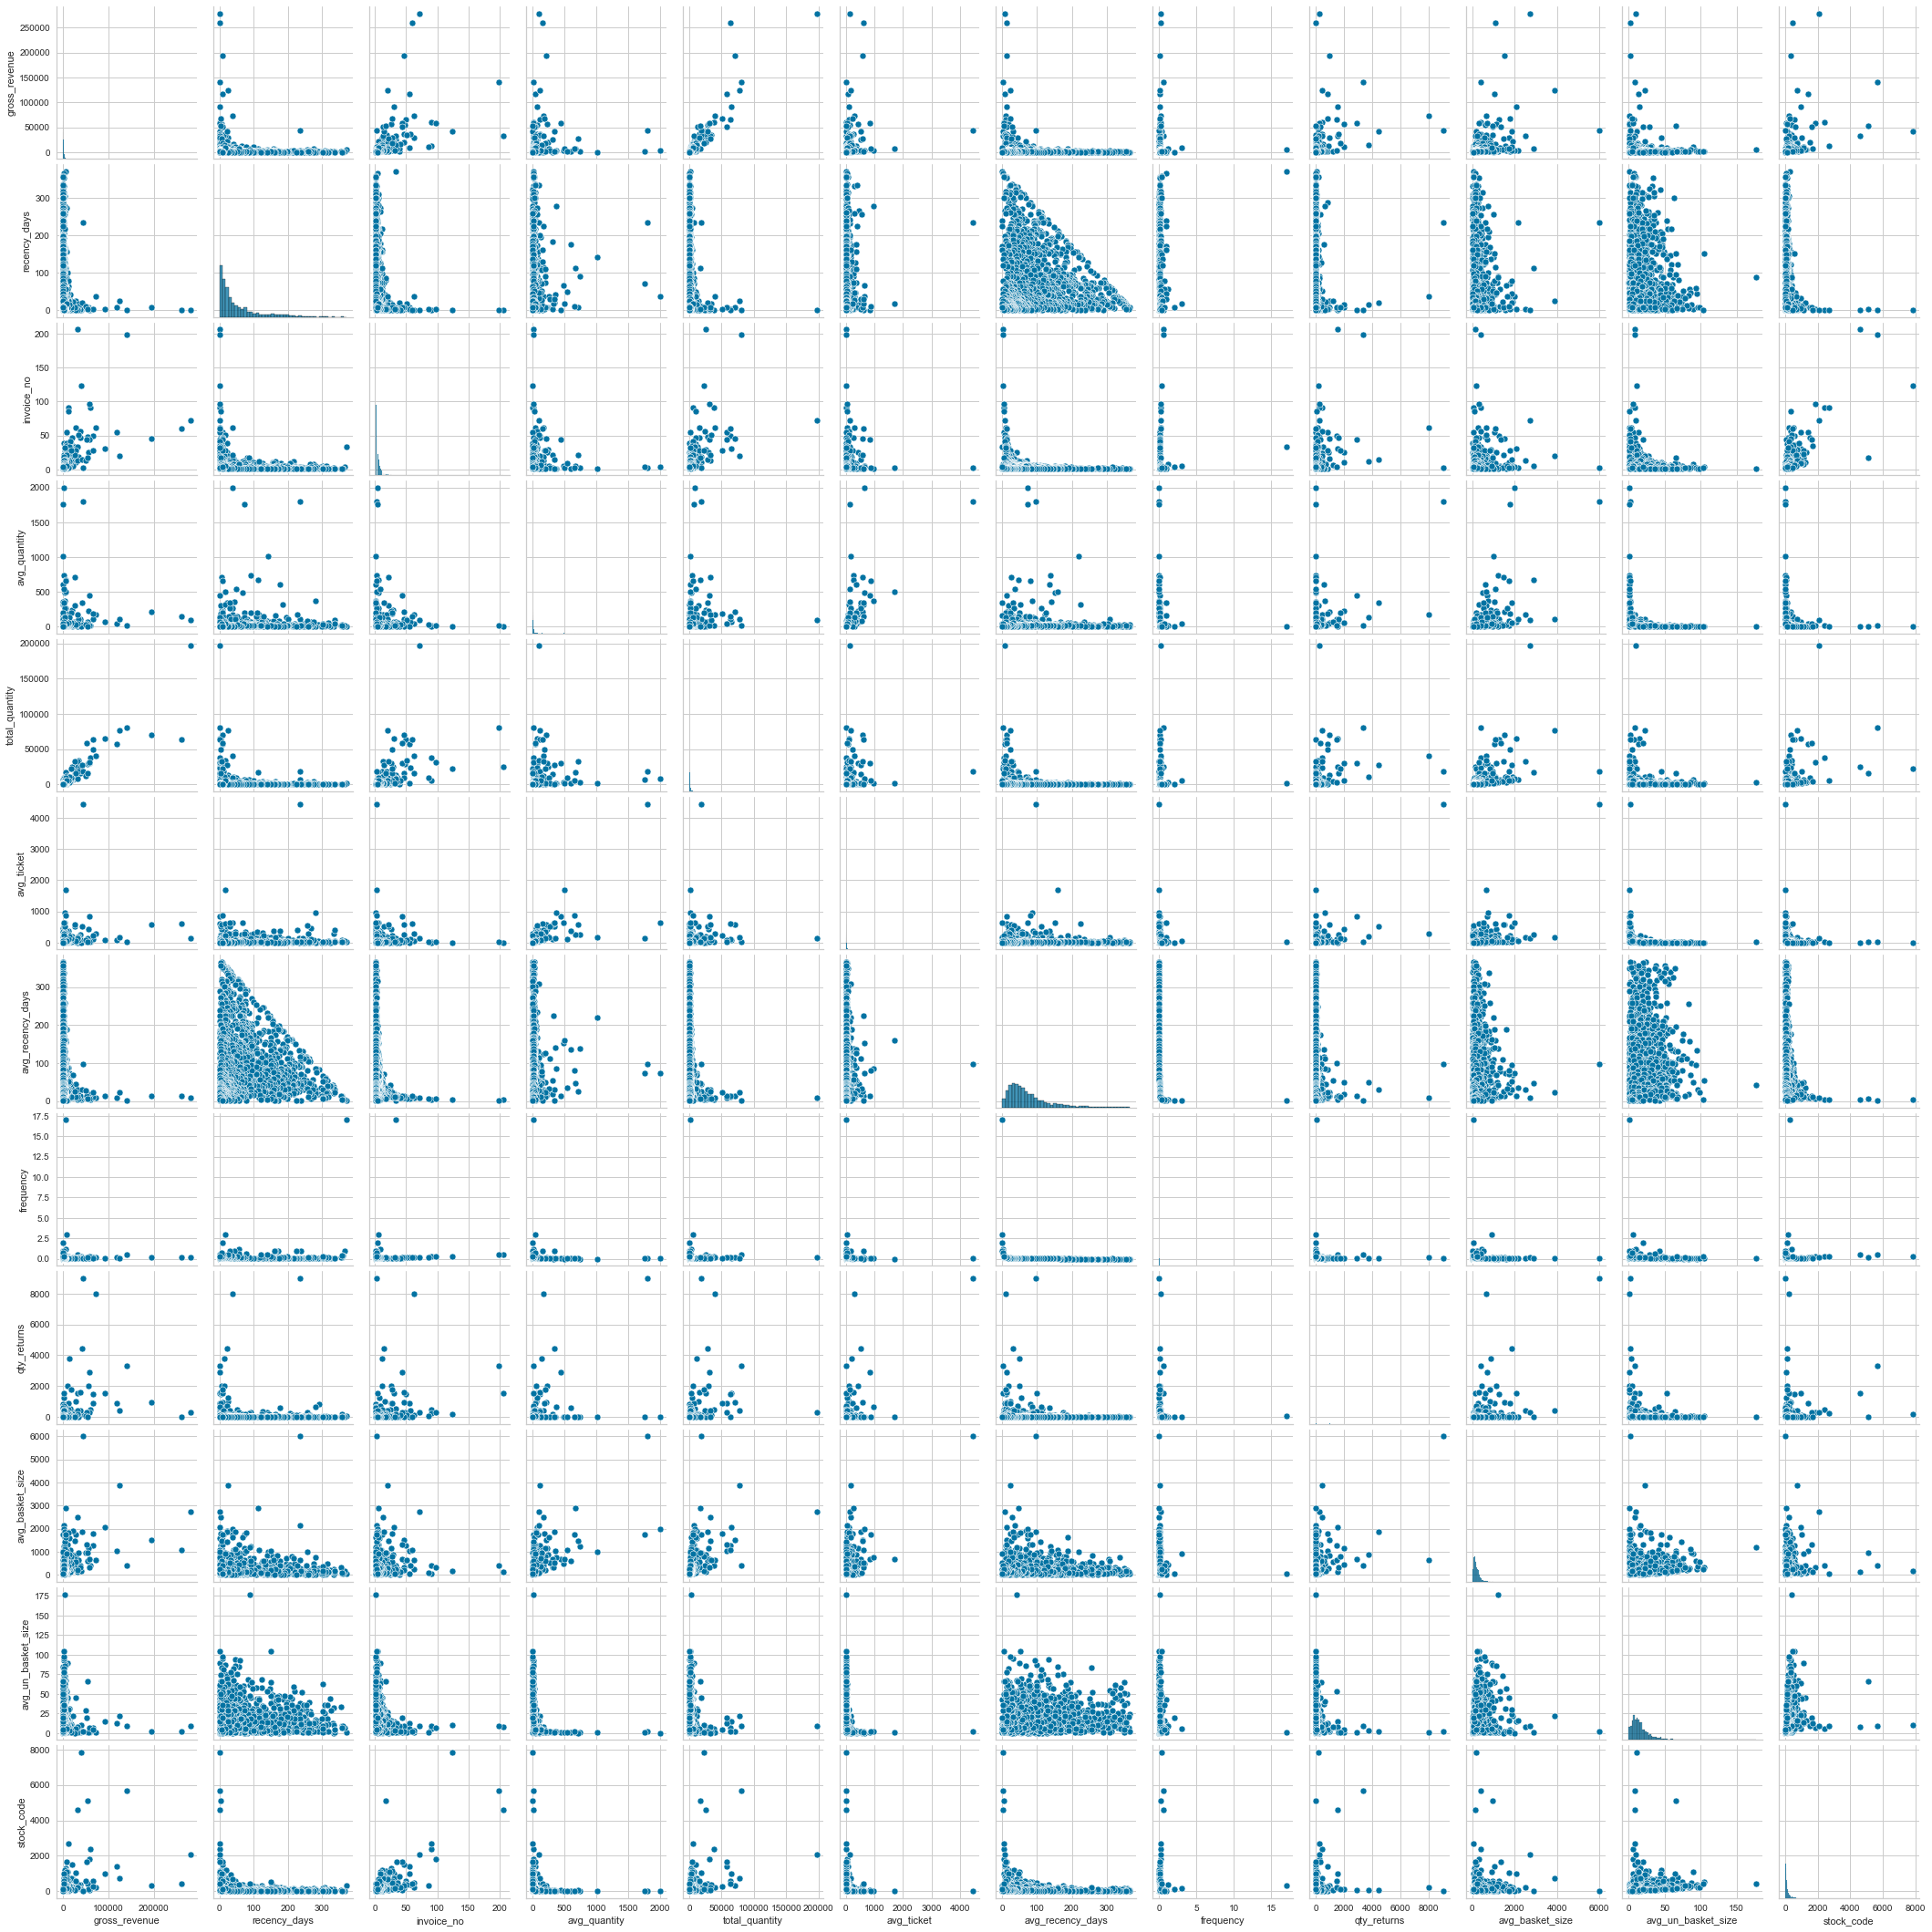

In [71]:
plt.figure(figsize=(20,12))
sns.pairplot(df41)

In [217]:
cols_to_drop = ['avg_quantity', 'avg_ticket', 'invoice_no', 'avg_ticket', 'avg_un_basket_size', 'avg_recency_days', ]

## 4.3 Embedding study

In [101]:
# df43 = df4.drop(columns=['customer_id'], axis=1).copy()

cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'total_quantity', 'frequency', 'qty_returns', 'avg_basket_size']
df43 = df4[cols_selected].copy() 

In [102]:
mm = pp.MinMaxScaler()

df43['gross_revenue']      = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']       = mm.fit_transform(df43[['recency_days']])
# df43['invoice_no']         = mm.fit_transform(df43[['invoice_no']])
# df43['avg_quantity']       = mm.fit_transform(df43[['avg_quantity']])
df43['total_quantity']     = mm.fit_transform(df43[['total_quantity']])
# df43['avg_ticket']         = mm.fit_transform(df43[['avg_ticket']])
# df43['avg_recency_days']   = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']          = mm.fit_transform(df43[['frequency']])
df43['qty_returns']        = mm.fit_transform(df43[['qty_returns']])
df43['avg_basket_size']    = mm.fit_transform(df43[['avg_basket_size']])
# df43['avg_un_basket_size'] = mm.fit_transform(df43[['avg_un_basket_size']])
# df43['stock_code']         = mm.fit_transform(df43[['stock_code']])




In [103]:
X = df43.copy()

### 4.3.1 PCA

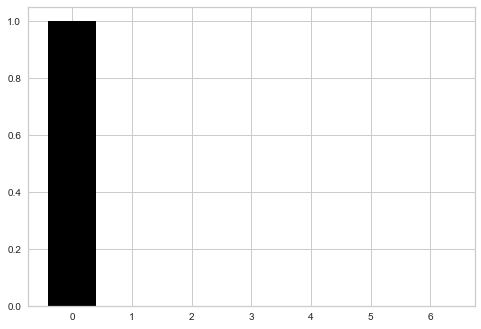

In [57]:
pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

# plot explained variables 
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)


<AxesSubplot:xlabel='0', ylabel='1'>

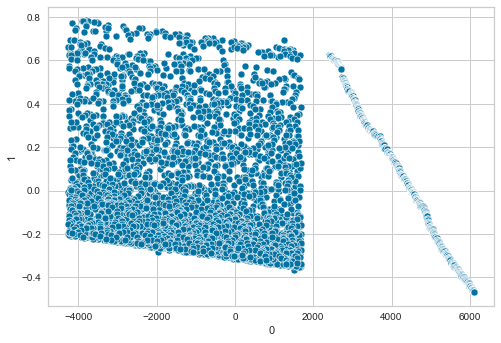

In [58]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

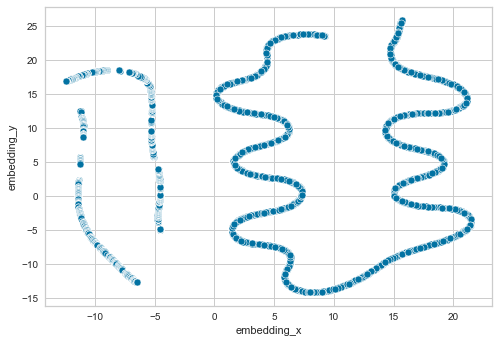

In [59]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data= df_pca)

### 4.3.3 t-SNE

c:\Users\diego\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\diego\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

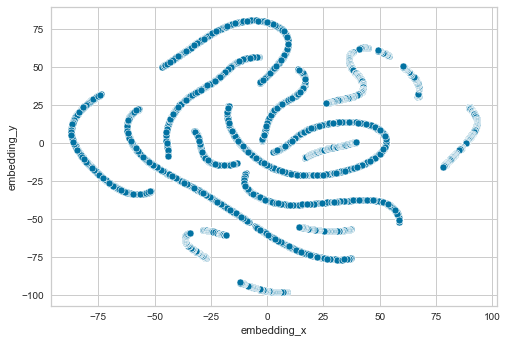

In [60]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data= df_pca)

### 4.3.4 Tree-Based Embedding

Tree-Based Embedding is a tool used to organize cluster with a target variable that, in this case, is the **Gross Revenue**.

It is a great method to create embedding for clustering when may explain the cluster's proximity but not the points similarity between them

In [117]:

# training dataset

X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [118]:
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

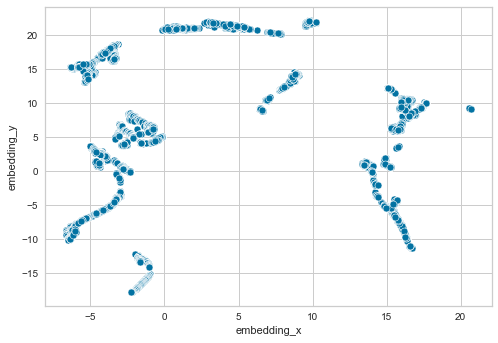

In [119]:
# Reducer dimensionality

# reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)

reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data= df_tree)

# 5.0 DATA PREPARATION

- Standardization / Normalization --> Normal Distribution
- Rescale --> It's not required data from normal distribution

1. Normal Distribution + No Outliers --> Standard Scaler
2. Normal Distribution + Outliers --> Robust Scaler
3. Non Normal Distribution --> MinMaxScaler


**Normal Distribution Test**
- OQ Plot - Quantile Plot
- KS Test - Kolgomorov Smirnoff --> p-value > 0.5 = Normal else, non normal distribution

**Outliers Detection**
- BoxPlot
- IRQ * 2.5 --> Above this values, then it is a outlier
- Z-Score 

In [107]:
df5 = df_tree.copy()
#df5_aux = df4.copy()

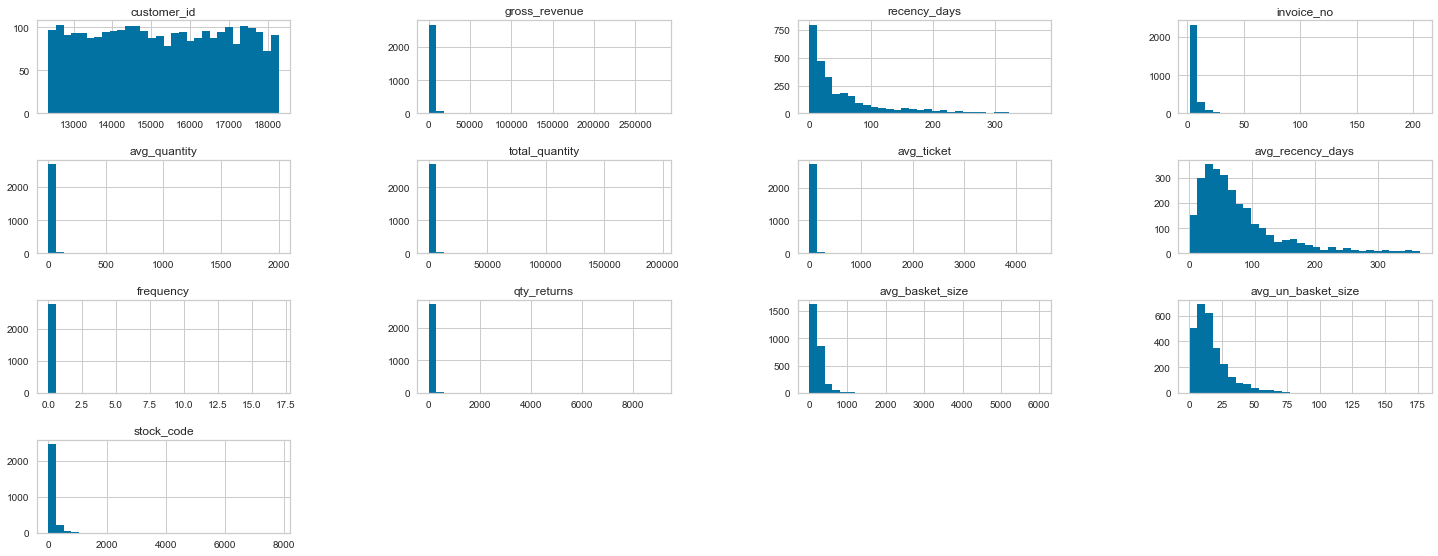

In [61]:
ax = df5.hist(bins=30, figsize = (25,12), layout=(5,4));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [281]:
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

# df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
# df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
# df5['invoice_no'] = mm.fit_transform(df5[['invoice_no']])
# df5['avg_quantity'] = mm.fit_transform(df5[['avg_quantity']])
# df5['total_quantity'] = mm.fit_transform(df5[['total_quantity']])
# df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])
# df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']])
# df5['frequency'] = mm.fit_transform(df5[['frequency']])
# df5['qty_returns'] = mm.fit_transform(df5[['qty_returns']])
# df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])
# df5['avg_un_basket_size'] = mm.fit_transform(df5[['avg_un_basket_size']])
# df5['stock_code'] = mm.fit_transform(df5[['stock_code']])

Gross revenue does not present a normal distribution (it will be treated in the next cycles)

# 6.0 FEATURE SELECTION

In [65]:
df6 = df_tree.copy()

In [66]:
# df6 = df6.drop(columns=cols_to_drop)
df6.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

#  7.0 HYPERPARAMETER FINE-TUNING

In [120]:
X = df_tree.copy()

In [122]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## 7.1 K-Means

In [123]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

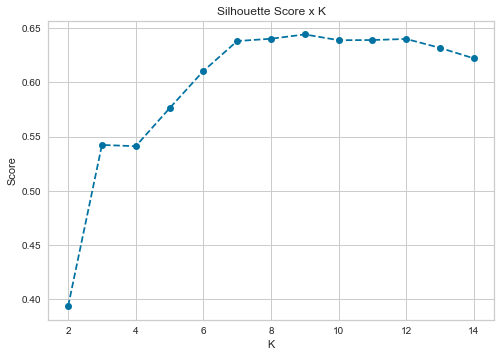

In [124]:
plt.plot(clusters, kmeans_list,linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Silhouette Score x K')

## 7.2 GMM

In [125]:
gmm_list = []

for k in clusters:
# model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

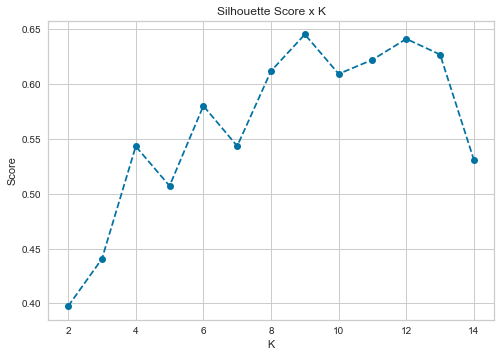

In [126]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Silhouette Score x K')

## 7.3 Hierarchical clustering

In [303]:
# # model training and training
# hc_model = hc.linkage(X, 'ward')

In [382]:
# hc.dendrogram(
#     hc_model,
#     leaf_rotation=90,
#     leaf_font_size=8
# )

# plt.plot()

In [383]:
# from os import truncate


# hc.dendrogram(
#     hc_model,
#     truncate_mode='lastp',
#     p=12,
#     leaf_rotation=90,
#     leaf_font_size=8,
#     show_contracted=True
# )

# plt.show()

### 7.3.1 HClustering Silhouette Score

In [127]:
hc_list = []
for k in clusters: 
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric= 'euclidean')
    hc_list.append(sil)

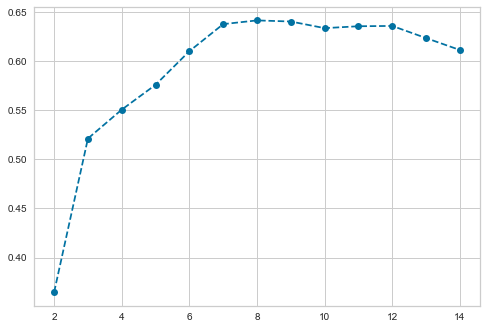

In [128]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

## 7.4 DBSCAN

In [129]:
eps = 0.15
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
print(sil)

0.4156117


In [130]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88], dtype=int64)

In [131]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

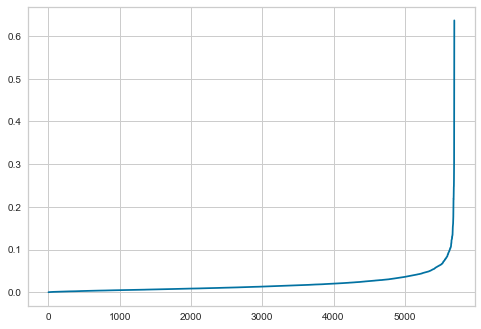

In [132]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)


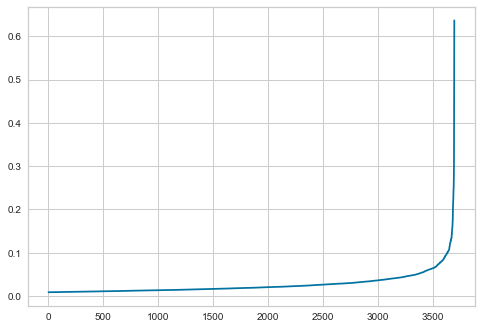

In [133]:
plt.plot(distances[2000:])

## 7.5 Results

In [134]:
df_results = pd.DataFrame({
    'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HC': hc_list,
}).T

df_results.columns = clusters

In [135]:
df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14
KMeans,0.393761,0.542290,0.541092,0.576089,0.610357,0.637948,0.640076,0.644062,0.638715,0.638879,0.639875,0.631626,0.621969
GMM,0.397523,0.440709,0.543341,0.507261,0.580256,0.543598,0.612052,0.645456,0.609415,0.622352,0.641386,0.627061,0.530866
HC,0.364611,0.521318,0.550752,0.576089,0.610357,0.637948,0.641730,0.640605,0.633839,0.635786,0.636086,0.623701,0.611541


## 7.6 Silhouette analysis

### 7.6.1 KMeans Silhouette

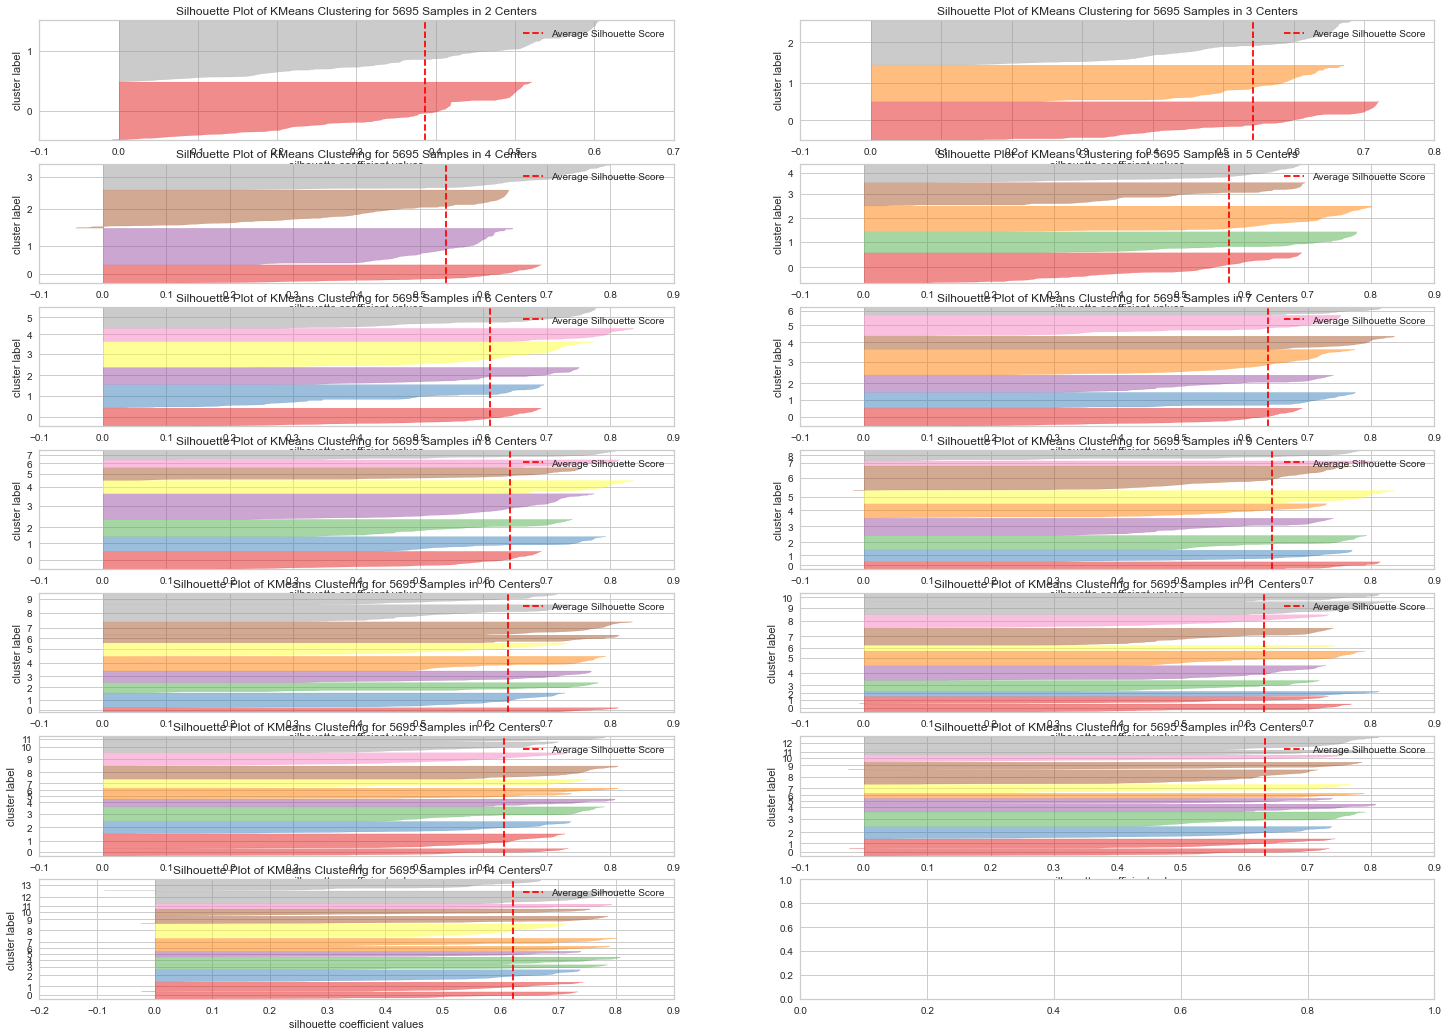

In [86]:
fig, ax = plt.subplots(7, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

### 7.6.2 HC Silhouette

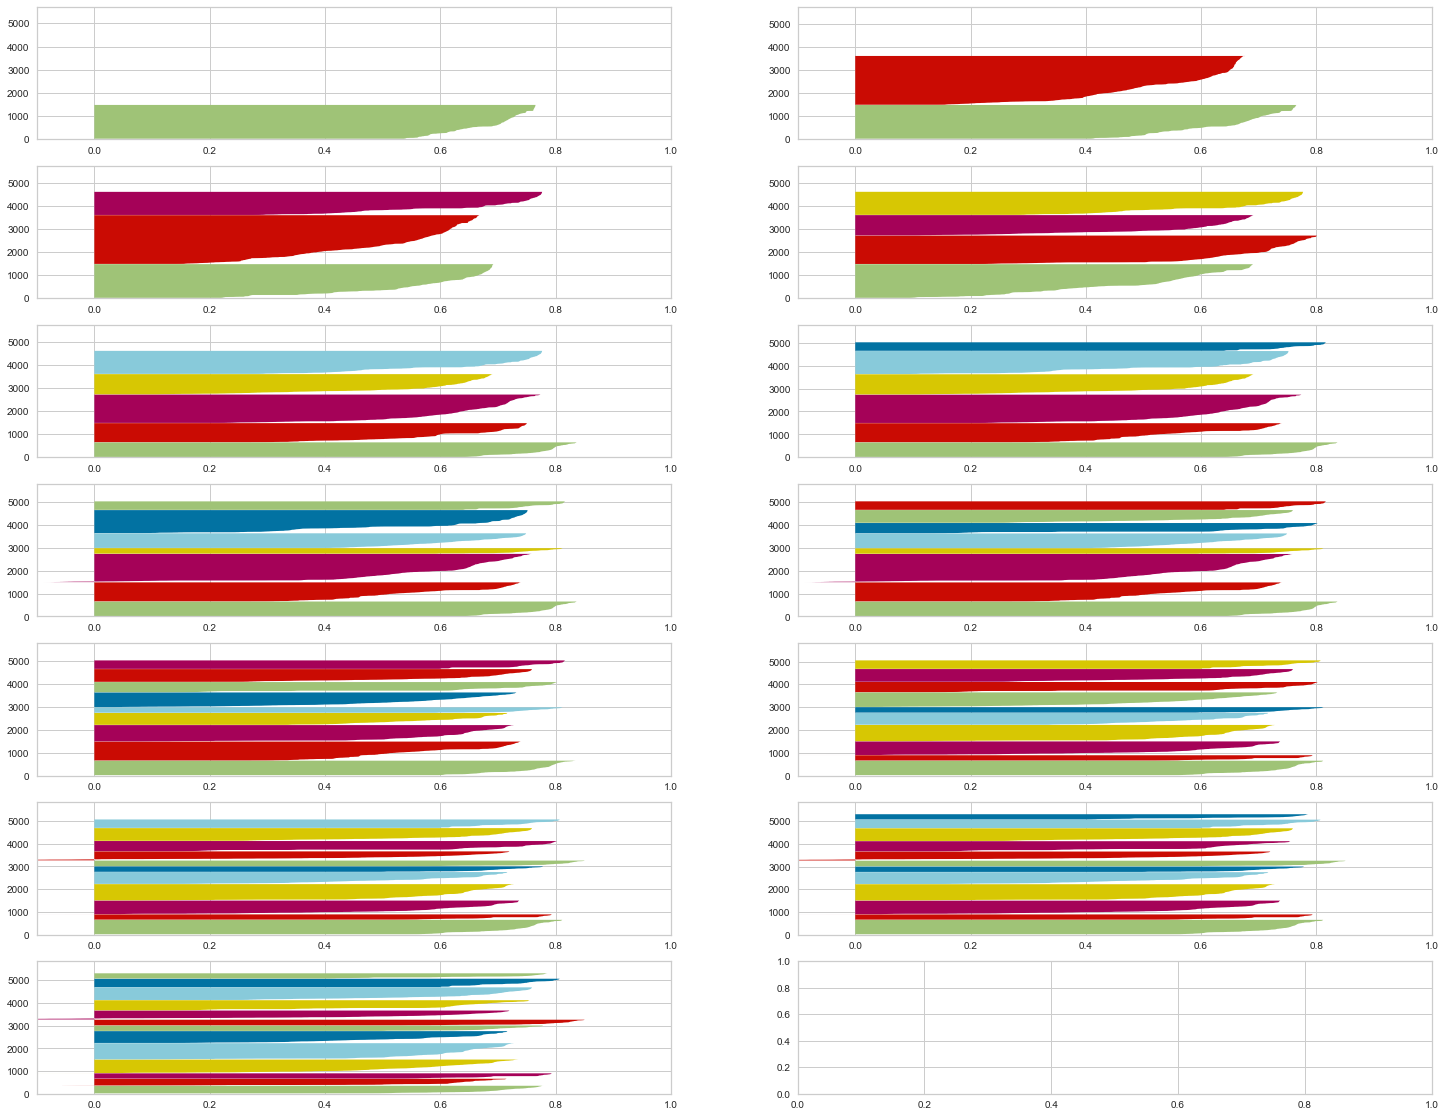

In [87]:
fig, ax = plt.subplots(7,2)
fig.set_size_inches(25,20)

for k in clusters:
    q, mod = divmod(k, 2)

    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(X) + (k+1)*10] )

    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # perfomance
    ss = m.silhouette_score(X, labels, metric='euclidean')

    samples_silhouette_values = m.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(k):
        
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]

        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]

        # limits
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)

        y_lower = y_upper + 10





#  8.0 MODEL TRAINING

## 8.1 Final Model

In [93]:
# model definition
k = 8
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [94]:
## WSS (Within-cluster Sum of Square)
print('wss value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'. format(m.silhouette_score(X, labels, metric='euclidean')))


wss value: 49484.8671875
SS value: 0.641504168510437


# 9.0 CLUSTER ANALYSIS

In [95]:
df9 = X.copy()
df9['cluster'] = labels

In [96]:
df9.head()

,embedding_x,embedding_y,cluster
0,14.107547,-1.355061,7
1,13.704563,1.103870,7
2,16.174988,-8.978461,5
3,4.215852,21.115473,2
4,-3.985928,2.134415,3


## 9.1 Visualization inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

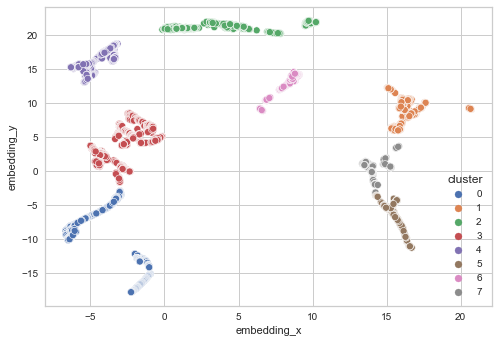

In [97]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [406]:
# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(X)
# visualizer.finalize()

## 9.2 2d plot

In [98]:
df_viz = df9.copy()
# # sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [409]:
# reducer = umap.UMAP(n_neighbors=20, random_state=42)
# embedding = reducer.fit_transform(X)

# # embedding
# df_viz['embedding_x'] = embedding[:, 0]
# df_viz['embedding_y'] = embedding[:, 1]

# #plot UMAP
# sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
#                 palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
#                 data= df_viz)

## 9.2 Cluster profile

In [99]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,total_quantity,frequency,qty_returns,avg_basket_size,cluster
0,17850,5391.21,372.0,1733.0,17.000000,40.0,50.970588,7
1,13047,3232.59,56.0,1390.0,0.028302,35.0,154.444444,7
2,12583,6705.38,2.0,5028.0,0.040323,50.0,335.200000,5
3,13748,948.25,95.0,439.0,0.017921,0.0,87.800000,2
4,15100,876.00,333.0,80.0,0.073171,22.0,26.666667,3


In [100]:
# number of customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg quantity
df_qty = df92[['total_quantity', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty, how='inner', on='cluster')

# frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# qty_returns
df_returns = df92[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

# avg_basket_size
df_basket = df92[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_basket, how='inner', on='cluster')

# # avg stock codes
# df_stock_code = df92[['stock_code', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_stock_code, how='inner', on='cluster')

# Avg invoice no
# df_invoice_no = df92[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg ticket
# df_ticket = df92[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,total_quantity,frequency,qty_returns,avg_basket_size
5,5,608,10.676032,9665.304079,44.884868,5641.754934,0.206497,245.085526,858.883039
7,7,441,7.743635,2610.212132,70.911565,1353.444444,0.355504,18.809524,475.166275
1,1,704,12.361721,1585.338267,53.234375,889.465909,0.111391,13.656250,262.572040
6,6,371,6.514486,1285.662372,154.522911,459.390836,1.000000,2.436658,459.390836
2,2,826,14.503951,880.160230,81.185230,428.140436,0.222354,6.835351,184.054267
4,4,634,11.132572,503.485331,121.506309,243.362776,0.560229,3.856467,172.165523
3,3,1233,21.650571,304.541792,161.281427,117.021898,0.800100,1.424980,99.721864
0,0,878,15.417032,70.921367,193.145786,18.800683,0.979196,0.455581,18.074005


# 10.0 DEPLOY TO PRODUCTION